In [ ]:
# PyTorch and related libraries
!pip install -q torch torchvision torchaudio

# PyTorch Geometric for GNNs
!pip install -q torch-geometric

# Quantum computing frameworks
!pip install -q pennylane qiskit

# PyTDC (Therapeutic Data Commons)
!pip install -q pytdc

# Chemistry toolkit
!pip install -q rdkit-pypi

# Machine learning and metrics
!pip install -q scikit-learn

# Visualization
!pip install -q matplotlib seaborn

# Utilities
!pip install -q tqdm

In [2]:
# =========================
# Journal-ready Kaggle Notebook
# Quantum-Enhanced Few-Shot ADMET Prediction (GNN-only + QKS-only)
# =========================

# -------------------------
# 1) Imports
# -------------------------
import os, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
from torch_geometric.data import Data, DataLoader as GeoDataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.DataStructs import ConvertToNumpyArray

import pennylane as qml
from tdc.single_pred import adme

In [3]:
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 150

# -------------------------
# 2) Device, dirs, reproducibility
# -------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)
SEED = 42
def seed_everything(s=SEED):
    random.seed(s); np.random.seed(s); torch.manual_seed(s)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(s)
seed_everything()

Device: cuda


In [5]:
# -------------------------
# 3) Configurable hyperparameters
# -------------------------
ADME_ENDPOINTS = ['half_life_obach']
N_WAY = 2
K_SHOT = 5
Q_QUERY = 10
EPISODES_PER_EPOCH = 100
EPOCHS = 100
N_EPISODES_EVAL = 200
N_QKS_QUBITS = 16
GNN_HIDDEN = 128
GNN_OUT = 64
LR = 1e-3
PATIENCE_ES = 10
MIN_DELTA = 1e-4

In [7]:
# -------------------------
# 4) Helpers: SMILES -> ECFP & Graph
# -------------------------
def smiles_to_ecfp(smiles, radius=2, nBits=1024):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None: return np.zeros(nBits, dtype=np.float32)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)
        arr = np.zeros((nBits,), dtype=np.float32)
        ConvertToNumpyArray(fp, arr)
        return arr
    except:
        return np.zeros(nBits, dtype=np.float32)

def mol_to_graph(smiles, y):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: return None
    atom_nums = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    x = torch.tensor(atom_nums, dtype=torch.float32).unsqueeze(1)
    edges = []
    for bond in mol.GetBonds():
        a,b = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        edges.append([a,b]); edges.append([b,a])
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2,0), dtype=torch.long)
    y_t = torch.tensor([y], dtype=torch.float32)
    return Data(x=x, edge_index=edge_index, y=y_t, smiles=smiles)

In [8]:
# -------------------------
# 5) QKS (PennyLane)
# -------------------------
n_qubits = N_QKS_QUBITS
dev = qml.device('default.qubit', wires=n_qubits)

@qml.qnode(dev)
def _qks_circuit(sample_angles):
    for i in range(n_qubits):
        qml.RY(sample_angles[i]*np.pi, wires=i)
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

def qks_feature_from_ecfp(ecfp_vec):
    v = np.zeros(n_qubits, dtype=np.float32)
    v[:min(len(ecfp_vec), n_qubits)] = ecfp_vec[:n_qubits]
    if v.max()>0: v /= (v.max()+1e-9)
    return np.array(_qks_circuit(v), dtype=np.float32)

# -------------------------
# 6) GNN Encoder
# -------------------------
class GNNEncoder(nn.Module):
    def __init__(self, in_channels=1, hidden_channels=GNN_HIDDEN, out_dim=GNN_OUT):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, out_dim)
        self.dropout = nn.Dropout(0.2)
    def forward(self, x, edge_index, batch):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        return self.lin(x)

In [9]:
# -------------------------
# 7) Few-shot episode sampling
# -------------------------
def sample_episode(df, N_way=N_WAY, K_shot=K_SHOT, Q_query=Q_QUERY):
    labels = df['Y'].astype(int).values
    classes = np.unique(labels)
    chosen = np.random.choice(classes, N_way, replace=False)
    support_idx, query_idx = [], []
    for c in chosen:
        idx = np.where(labels==c)[0]
        s = np.random.choice(idx, size=K_shot+Q_query, replace=len(idx)<(K_shot+Q_query))
        support_idx.extend(s[:K_shot]); query_idx.extend(s[K_shot:K_shot+Q_query])
    return support_idx, query_idx, chosen.tolist()

def euclidean_dist_torch(x,y):
    n,m = x.shape[0], y.shape[0]
    return ((x.unsqueeze(1).expand(n,m,-1)-y.unsqueeze(0).expand(n,m,-1))**2).sum(dim=2)

# -------------------------
# 8) Episodic prototypical training (GNN-only)
# -------------------------
def episodic_train_gnn(graphs, df, encoder, optimizer, episodes_per_epoch=EPISODES_PER_EPOCH, epochs=EPOCHS,
                       n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY, scheduler=None, early_stop=True, patience=PATIENCE_ES):
    encoder.train()
    history = {'loss':[], 'val_auc':[], 'val_ap':[]}
    best_val_auc = -np.inf; epochs_no_improve=0
    for epoch in range(epochs):
        epoch_losses = []
        for _ in range(episodes_per_epoch):
            s_idx, q_idx, _ = sample_episode(df, n_way, k_shot, q_query)
            sup_g = [graphs[i] for i in s_idx]; qry_g = [graphs[i] for i in q_idx]
            sup_emb = torch.cat([encoder(b.x.to(DEVICE), b.edge_index.to(DEVICE), b.batch.to(DEVICE)) 
                                 for b in GeoDataLoader(sup_g, batch_size=len(sup_g))], dim=0)
            qry_emb = torch.cat([encoder(b.x.to(DEVICE), b.edge_index.to(DEVICE), b.batch.to(DEVICE)) 
                                 for b in GeoDataLoader(qry_g, batch_size=len(qry_g))], dim=0)
            prototypes = torch.stack([sup_emb[i*k_shot:(i+1)*k_shot].mean(dim=0) for i in range(n_way)])
            dists = euclidean_dist_torch(qry_emb, prototypes)
            logits = -dists
            labels = torch.tensor([i for i in range(n_way) for _ in range(q_query)], dtype=torch.long, device=DEVICE)
            loss = nn.CrossEntropyLoss()(logits, labels)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
            epoch_losses.append(loss.item())
        mean_loss = np.mean(epoch_losses)
        history['loss'].append(mean_loss)
        print(f"[Epoch {epoch+1}/{epochs}] loss: {mean_loss:.4f}")
        
        # validation
        encoder.eval()
        val_aucs,val_aps = [],[]
        with torch.no_grad():
            for _ in range(30):
                s_idx,q_idx,_ = sample_episode(df,n_way,k_shot,q_query)
                sup_g = [graphs[i] for i in s_idx]; qry_g=[graphs[i] for i in q_idx]
                sup_emb = torch.cat([encoder(b.x.to(DEVICE),b.edge_index.to(DEVICE),b.batch.to(DEVICE)) 
                                     for b in GeoDataLoader(sup_g,batch_size=len(sup_g))],dim=0)
                qry_emb = torch.cat([encoder(b.x.to(DEVICE),b.edge_index.to(DEVICE),b.batch.to(DEVICE)) 
                                     for b in GeoDataLoader(qry_g,batch_size=len(qry_g))],dim=0)
                prototypes = torch.stack([sup_emb[i*k_shot:(i+1)*k_shot].mean(dim=0) for i in range(n_way)])
                dists = euclidean_dist_torch(qry_emb, prototypes)
                probs = torch.softmax(-dists,dim=1).cpu().numpy()
                labels_true = np.array([i for i in range(n_way) for _ in range(q_query)])
                try: val_auc=roc_auc_score(labels_true,probs[:,1])
                except: val_auc=0.5
                try: val_ap=average_precision_score(labels_true,probs[:,1])
                except: val_ap=0.5
                val_aucs.append(val_auc); val_aps.append(val_ap)
        mean_val_auc=np.mean(val_aucs); mean_val_ap=np.mean(val_aps)
        history['val_auc'].append(mean_val_auc); history['val_ap'].append(mean_val_ap)
        print(f"  Validation AUC: {mean_val_auc:.4f}, AP: {mean_val_ap:.4f}")
        encoder.train()

        if scheduler: scheduler.step(mean_loss)
        # early stopping
        if early_stop:
            if mean_val_auc>best_val_auc+MIN_DELTA:
                best_val_auc=mean_val_auc; epochs_no_improve=0
                torch.save(encoder.state_dict(),"models/best_encoder.pt")
            else: epochs_no_improve+=1
            if epochs_no_improve>=patience:
                print("Early stopping triggered.")
                break
    return encoder, history

# -------------------------
# 9) Episodic evaluation (GNN-only)
# -------------------------
def episodic_eval_gnn(graphs, df, encoder, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY, n_episodes=N_EPISODES_EVAL):
    encoder.eval(); all_labels=[]; all_probs=[]; accs=[]
    with torch.no_grad():
        for _ in range(n_episodes):
            s_idx,q_idx,_=sample_episode(df,n_way,k_shot,q_query)
            sup_g = [graphs[i] for i in s_idx]; qry_g=[graphs[i] for i in q_idx]
            sup_emb = torch.cat([encoder(b.x.to(DEVICE),b.edge_index.to(DEVICE),b.batch.to(DEVICE)) 
                                 for b in GeoDataLoader(sup_g,batch_size=len(sup_g))],dim=0)
            qry_emb = torch.cat([encoder(b.x.to(DEVICE),b.edge_index.to(DEVICE),b.batch.to(DEVICE)) 
                                 for b in GeoDataLoader(qry_g,batch_size=len(qry_g))],dim=0)
            prototypes = torch.stack([sup_emb[i*k_shot:(i+1)*k_shot].mean(dim=0) for i in range(n_way)])
            dists = euclidean_dist_torch(qry_emb, prototypes)
            probs = torch.softmax(-dists,dim=1).cpu().numpy()
            preds = np.argmax(probs,axis=1)
            labels_true = np.array([i for i in range(n_way) for _ in range(q_query)])
            all_labels.extend(labels_true); all_probs.extend(probs[:,1]); accs.append((preds==labels_true).mean())
    all_labels = np.array(all_labels); all_probs=np.array(all_probs)
    try: auc=roc_auc_score(all_labels,all_probs); ap=average_precision_score(all_labels,all_probs)
    except: auc,ap=float('nan'),float('nan')
    print(f"[GNN-only] AUC:{auc:.4f}, AP:{ap:.4f}, Acc:{np.mean(accs):.4f}")
    return {'auc':auc,'ap':ap,'acc':float(np.mean(accs))}

# -------------------------
# 10) QKS-only baseline
# -------------------------
def qks_only_classify(qks_feats, df, n_way=N_WAY, k_shot=K_SHOT, q_query=Q_QUERY, n_episodes=N_EPISODES_EVAL):
    all_labels=[]; all_probs=[]; accs=[]
    for _ in range(n_episodes):
        s_idx,q_idx,_=sample_episode(df,n_way,k_shot,q_query)
        X_sup = qks_feats[s_idx]; y_sup = np.array([i for i in range(n_way) for _ in range(k_shot)])
        X_qry = qks_feats[q_idx]; y_qry = np.array([i for i in range(n_way) for _ in range(q_query)])
        try:
            clf=LogisticRegression(multi_class='multinomial',max_iter=200).fit(X_sup,y_sup)
            probs=clf.predict_proba(X_qry); preds=np.argmax(probs,axis=1)
        except:
            preds=np.random.randint(0,n_way,len(y_qry)); probs=np.random.rand(len(y_qry),2)
        all_labels.extend(y_qry); all_probs.extend(probs[:,1]); accs.append((preds==y_qry).mean())
    all_labels=np.array(all_labels); all_probs=np.array(all_probs)
    try: auc=roc_auc_score(all_labels,all_probs); ap=average_precision_score(all_labels,all_probs)
    except: auc,ap=float('nan'),float('nan')
    print(f"[QKS-only] AUC:{auc:.4f}, AP:{ap:.4f}, Acc:{np.mean(accs):.4f}")
    return {'auc':auc,'ap':ap,'acc':float(np.mean(accs))}

Found local copy...
Loading...
Done!



Endpoint: half_life_obach
Loaded 667 valid molecules.


100%|██████████| 667/667 [00:19<00:00, 34.42it/s]


[Epoch 1/100] loss: 0.6925
  Validation AUC: 0.6937, AP: 0.7882
[Epoch 2/100] loss: 0.6796
  Validation AUC: 0.7373, AP: 0.8321
[Epoch 3/100] loss: 0.6620
  Validation AUC: 0.7707, AP: 0.8395
[Epoch 4/100] loss: 0.6549
  Validation AUC: 0.7537, AP: 0.8395
[Epoch 5/100] loss: 0.6833
  Validation AUC: 0.6887, AP: 0.7835
[Epoch 6/100] loss: 0.6526
  Validation AUC: 0.8047, AP: 0.8602
[Epoch 7/100] loss: 0.6627
  Validation AUC: 0.7750, AP: 0.8518
[Epoch 8/100] loss: 0.6566
  Validation AUC: 0.8287, AP: 0.8820
[Epoch 9/100] loss: 0.6067
  Validation AUC: 0.6513, AP: 0.7790
[Epoch 10/100] loss: 0.6407
  Validation AUC: 0.8043, AP: 0.8641
[Epoch 11/100] loss: 0.6117
  Validation AUC: 0.7240, AP: 0.7846
[Epoch 12/100] loss: 0.5940
  Validation AUC: 0.7227, AP: 0.8145
[Epoch 13/100] loss: 0.6471
  Validation AUC: 0.6347, AP: 0.7563
[Epoch 14/100] loss: 0.6533
  Validation AUC: 0.7317, AP: 0.8117
[Epoch 15/100] loss: 0.6323
  Validation AUC: 0.7773, AP: 0.8334
[Epoch 16/100] loss: 0.6688
  Vali

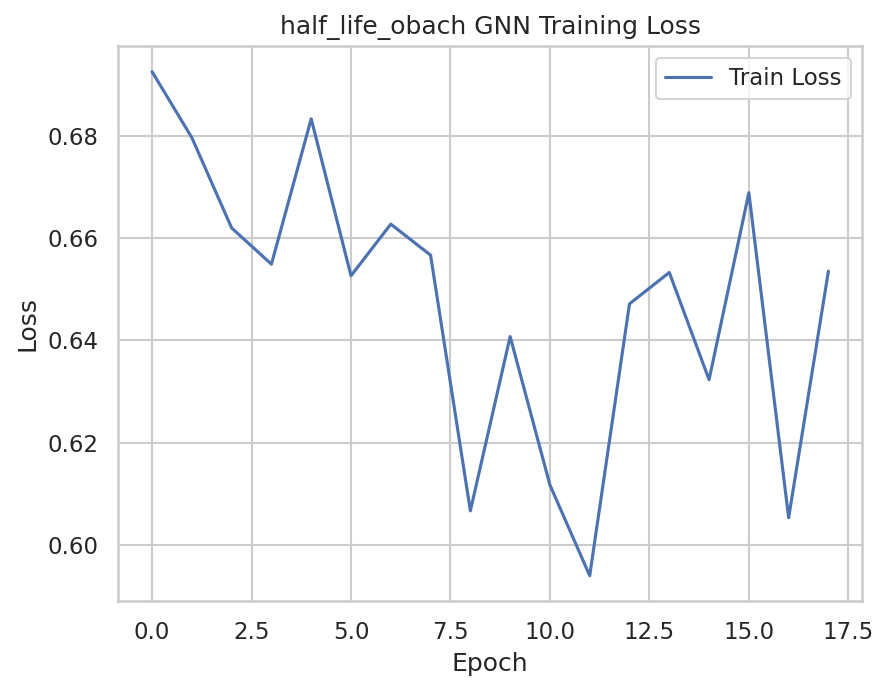

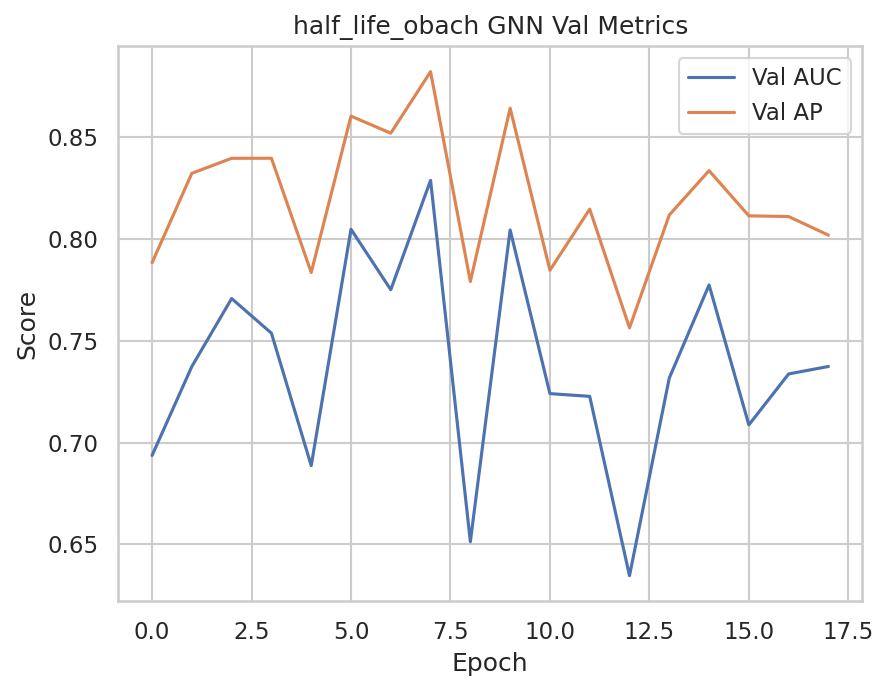

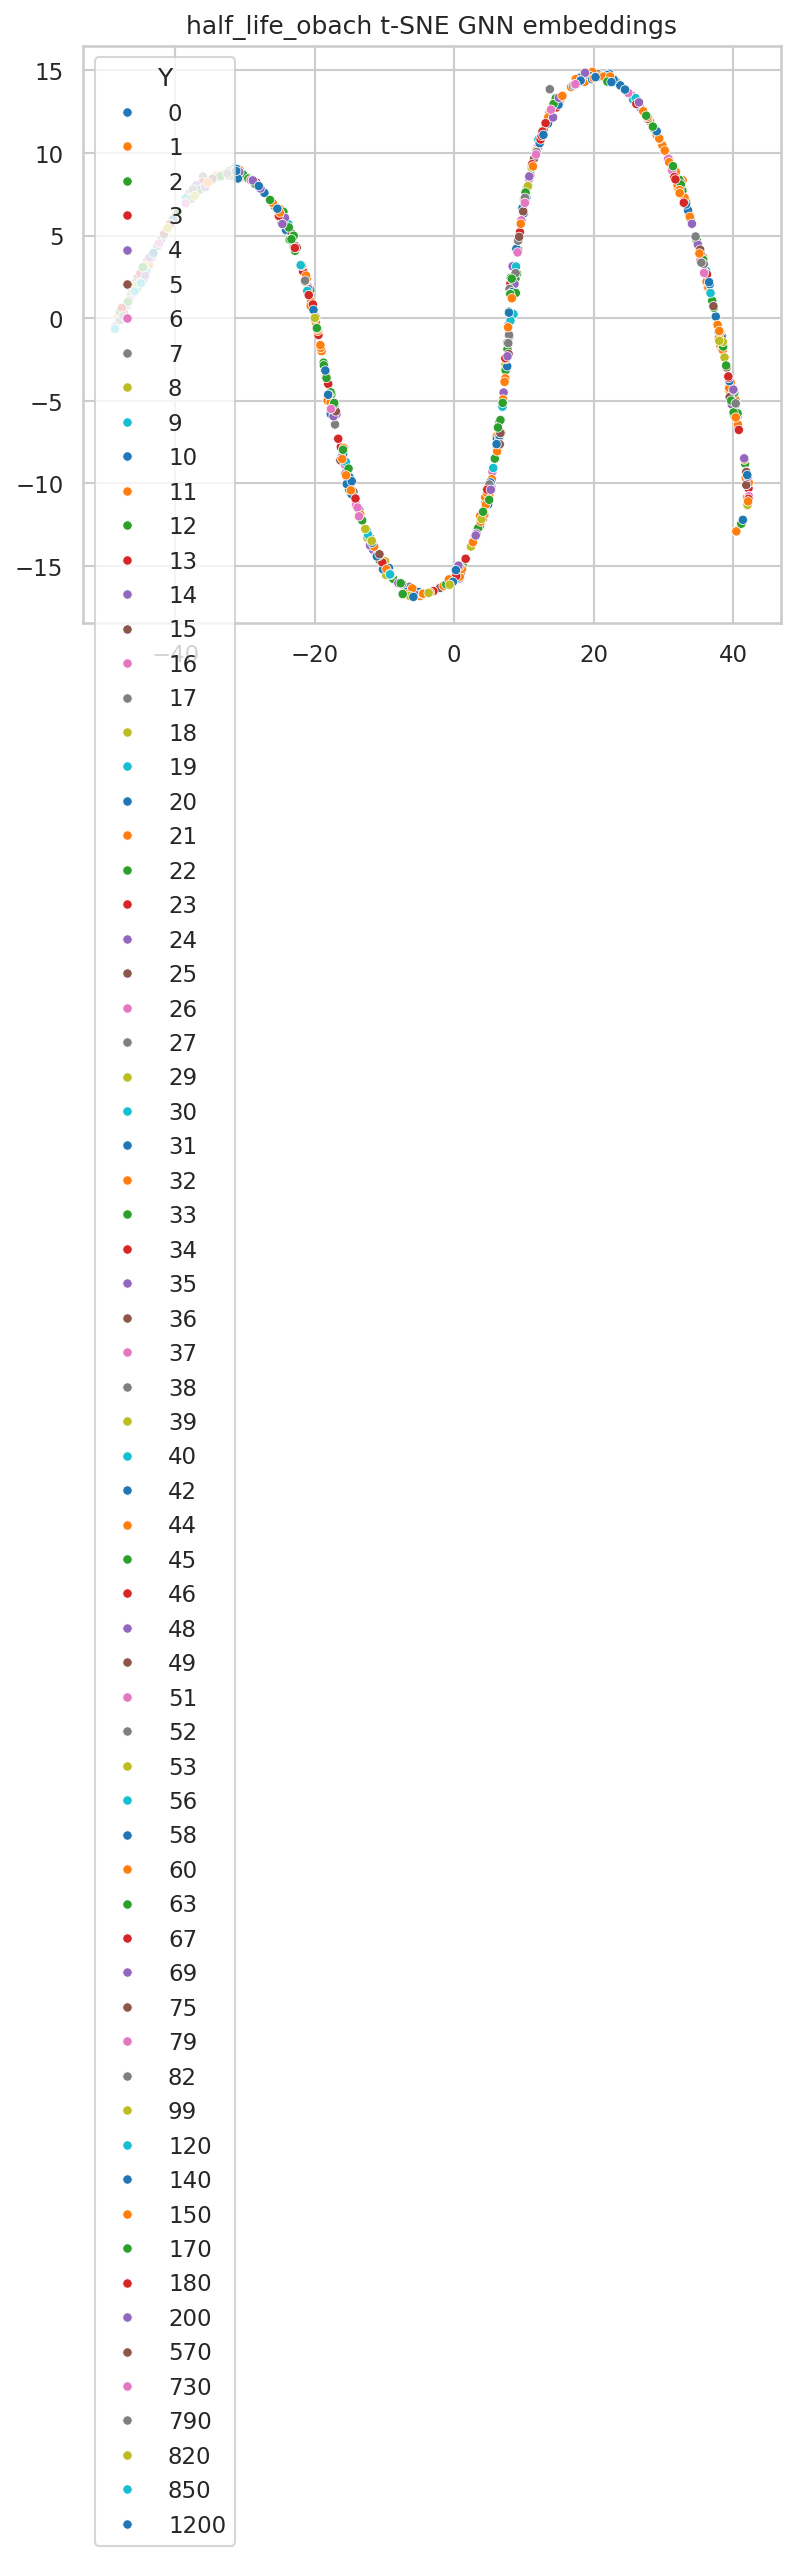

In [10]:
# -------------------------
# 11) High-level pipeline per endpoint
# -------------------------
results_summary = {}
for endpoint in ADME_ENDPOINTS:
    print("\n"+"="*40); print("Endpoint:",endpoint); print("="*40)
    df_raw = adme.ADME(name=endpoint).get_data().reset_index(drop=True)
    graphs, keep_rows = [],[]
    for idx,row in df_raw.iterrows():
        g = mol_to_graph(row['Drug'], row['Y'])
        if g is not None: graphs.append(g); keep_rows.append(row)
    df = pd.DataFrame(keep_rows).reset_index(drop=True)
    print(f"Loaded {len(df)} valid molecules.")

    # QKS features
    X_ecfp = np.stack([smiles_to_ecfp(g.smiles) for g in graphs])
    Z = np.zeros((len(graphs), n_qubits),dtype=np.float32)
    for i in tqdm(range(len(X_ecfp))): Z[i] = qks_feature_from_ecfp(X_ecfp[i])
    
    # initialize GNN
    encoder = GNNEncoder(in_channels=1, hidden_channels=GNN_HIDDEN,out_dim=GNN_OUT).to(DEVICE)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=7, verbose=True)
    
    # train GNN-only
    encoder_trained, history = episodic_train_gnn(graphs, df, encoder, optimizer, scheduler=scheduler)

    # plot learning curves
    plt.figure(); plt.plot(history['loss'],label='Train Loss'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title(f"{endpoint} GNN Training Loss"); plt.legend(); plt.savefig(f"plots/{endpoint}_gnn_train_loss.png", dpi=300)
    plt.figure(); plt.plot(history['val_auc'],label='Val AUC'); plt.plot(history['val_ap'],label='Val AP'); plt.xlabel('Epoch'); plt.ylabel('Score'); plt.title(f"{endpoint} GNN Val Metrics"); plt.legend(); plt.savefig(f"plots/{endpoint}_gnn_val_metrics.png", dpi=300)

    # evaluate
    res_gnn = episodic_eval_gnn(graphs, df, encoder_trained)
    res_qks = qks_only_classify(Z, df)
    
    # t-SNE embeddings
    encoder_trained.eval()
    with torch.no_grad():
        g_embs = np.vstack([encoder_trained(b.x.to(DEVICE), b.edge_index.to(DEVICE), b.batch.to(DEVICE)).cpu().numpy() for b in GeoDataLoader(graphs,batch_size=64)])
    tsne = TSNE(n_components=2, random_state=SEED,perplexity=30)
    emb2 = tsne.fit_transform(g_embs)
    plt.figure(figsize=(6,5)); sns.scatterplot(x=emb2[:,0],y=emb2[:,1],hue=df['Y'].astype(int),palette='tab10',s=20); plt.title(f"{endpoint} t-SNE GNN embeddings"); plt.savefig(f"plots/{endpoint}_tsne_gnn.png",dpi=300)
    
    results_summary[endpoint] = {'gnn_only': res_gnn, 'qks_only': res_qks}

# -------------------------
# 12) Final summary table
# -------------------------
summary_rows=[]
for ep,res in results_summary.items():
    for model,metrics in res.items():
        summary_rows.append({'Endpoint':ep,'Model':model,'AUC':metrics['auc'],'AP':metrics['ap'],'Acc':metrics['acc']})
df_results = pd.DataFrame(summary_rows)
print("\nFinal Results Summary:")
print(df_results)
df_results.to_csv("results_summary.csv", index=False)
print("All plots and models saved under 'plots/' and 'models/'.")